In [2]:
# Dans une cellule, forcez la mise à jour de pip avant tout
!pip install --upgrade pip

!pip install wordcloud -q
!pip install spacy
!python -m spacy download fr_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 90.6 MB/s  0:00:00m0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')


In [9]:
import spacy
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

from wordcloud import WordCloud

## Preprocessing

In [4]:
from create_dataframe import prepare_legislatives_dataset

csv_p = "/home/onyxia/work/NLP_rendus/.ipynb_checkpoints/data/legislatives_1981.csv"
txt_p = "/home/onyxia/work/NLP_rendus/.ipynb_checkpoints/data/legislatives_1981"

df_final = prepare_legislatives_dataset(csv_p, txt_p)

With this code, we will do:
1. **OCR artifact cleaning:** remove line breaks, special characters, and isolated small numbers.
2. **Text normalization:** convert text to lowercase, remove unnecessary punctuation.
3. **Tokenization and filtering:** remove stopwords, punctuation, and whitespace tokens.
4. **Lemmatization:** reduce words to their base form.

These operations reduce noise, standardize the text, and retain only meaningful lexical information, thereby improving the robustness and interpretability of subsequent NLP models.

In [5]:
############# Load the French language model ############

nlp = spacy.load("fr_core_news_sm")

In [6]:
############# functions to clean data ############

def clean_ocr(text):
    """Basic cleaning of OCR artifacts and noise."""
    # Remove unnecessary line breaks and unusual special characters
    text = re.sub(r'\n+', ' ', text)
    text = re.sub(r'[^\w\s\.,;!?]', '', text) 
    # Remove isolated small digit sequences (often page numbers or scan errors)
    text = re.sub(r'\b\d{1,2}\b', '', text)
    return text.strip()

def preprocess_text(text, use_lemma=True):
    """Normalization: Lowercasing, OCR cleaning, Tokenization, Stopwords removal, and Lemmatization."""
    text = clean_ocr(text.lower())
    doc = nlp(text)
    tokens = []
    for token in doc:
        # Filter out stop words, punctuation, and whitespace
        if not token.is_stop and not token.is_punct and not token.is_space and token.is_alpha and len(token) > 2:
            if use_lemma:
                tokens.append(token.lemma_)
            else:
                tokens.append(token.text)
                
    return " ".join(tokens)

print("Lancement du nettoyage avec spaCy (cela peut prendre 1 à 2 minutes)...")
df_final["clean_text"] = df_final["text_content"].apply(preprocess_text)
print("Nettoyage terminé")

Lancement du nettoyage avec spaCy (cela peut prendre 1 à 2 minutes)...
Nettoyage terminé


--- Génération du nuage pour la catégorie : Parti socialiste unifié ---


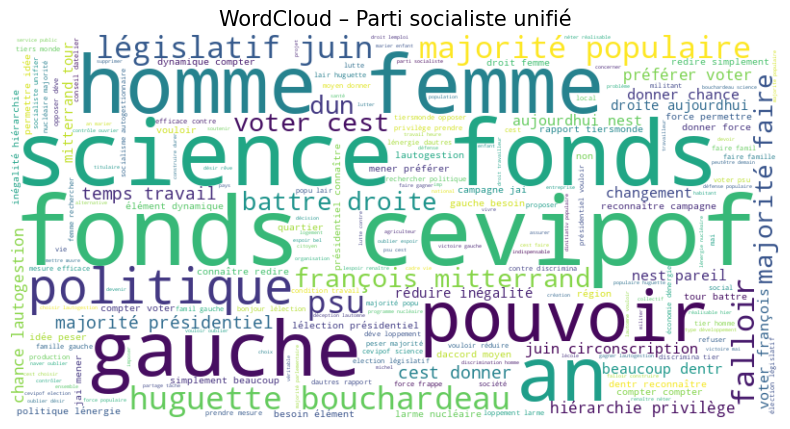

--- Génération du nuage pour la catégorie : Parti communiste français ---


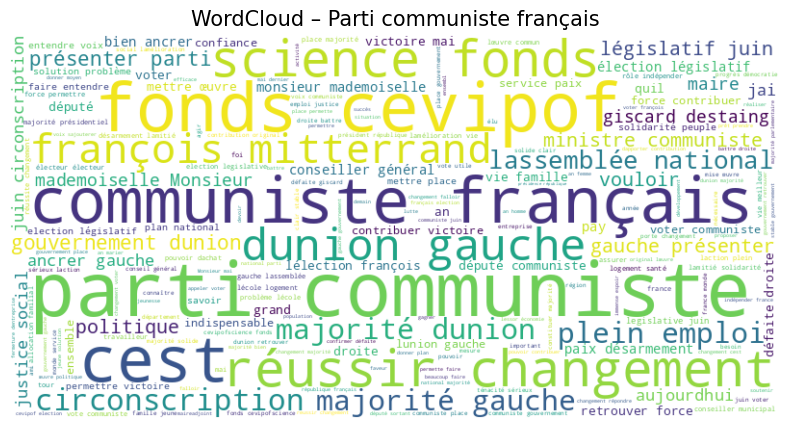

--- Génération du nuage pour la catégorie : Parti socialiste;Mouvement des radicaux de gauche ---


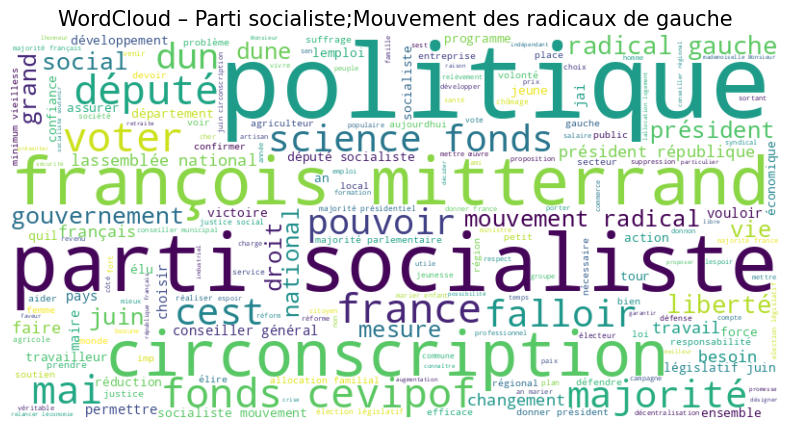

--- Génération du nuage pour la catégorie : Rassemblement pour la République;Union pour la démocratie française ---


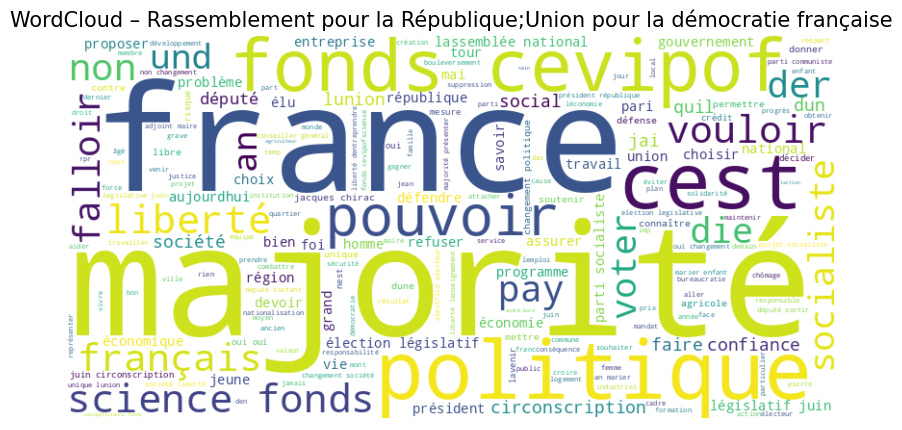

--- Génération du nuage pour la catégorie : Parti socialiste ---


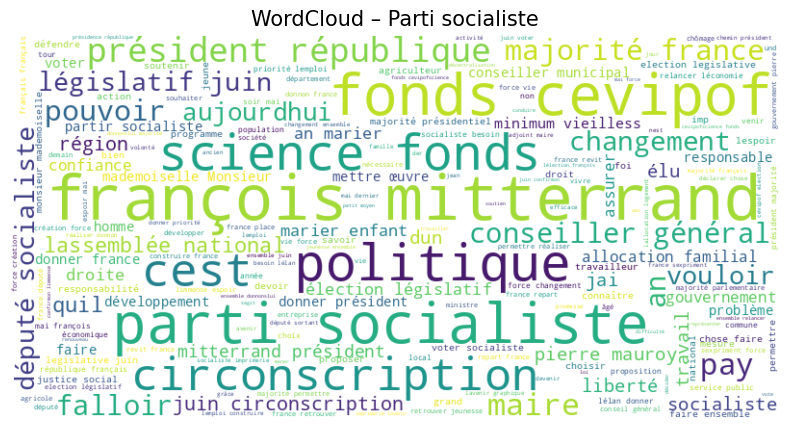

--- Génération du nuage pour la catégorie : Union pour la démocratie française ---


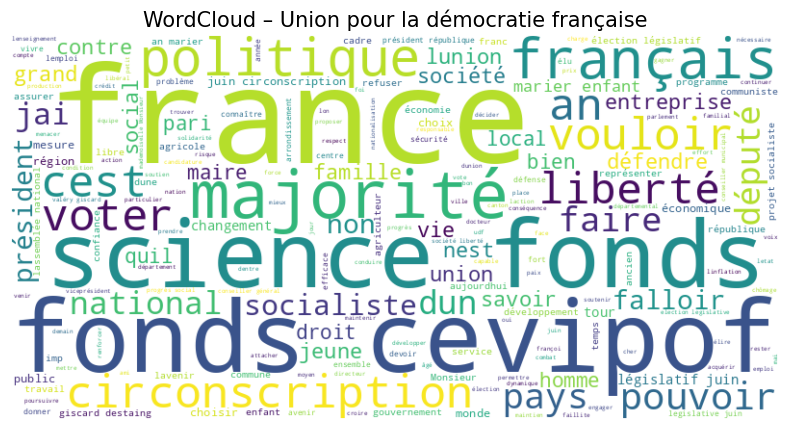

--- Génération du nuage pour la catégorie : Rassemblement pour la République ---


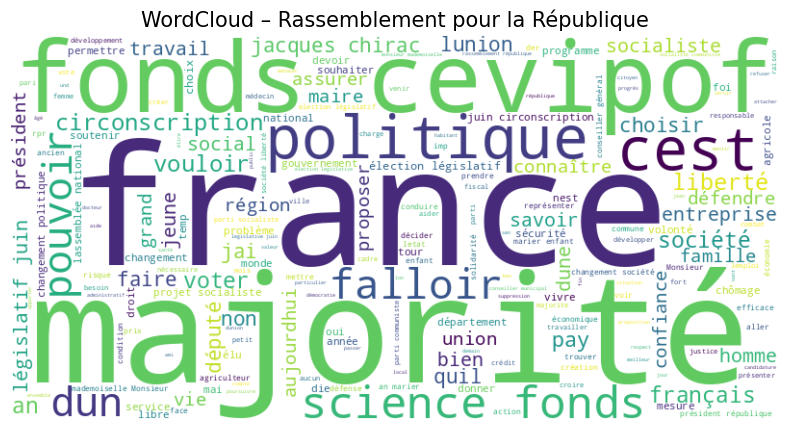

--- Génération du nuage pour la catégorie : Lutte ouvrière ---


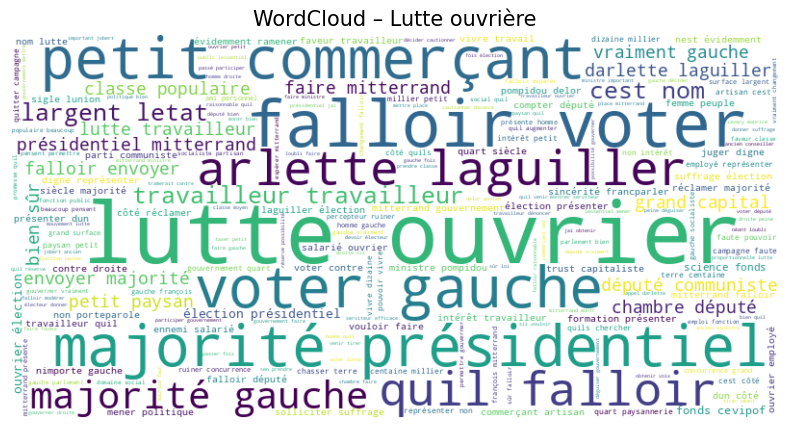

--- Génération du nuage pour la catégorie : Front national ---


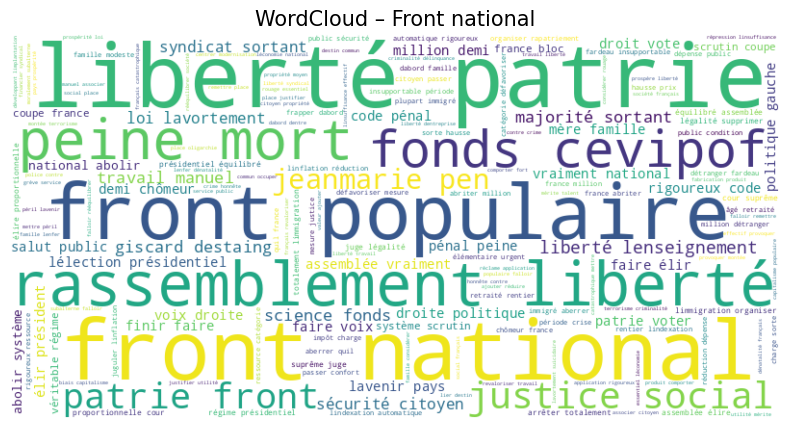

--- Génération du nuage pour la catégorie : Mouvement des radicaux de gauche ---


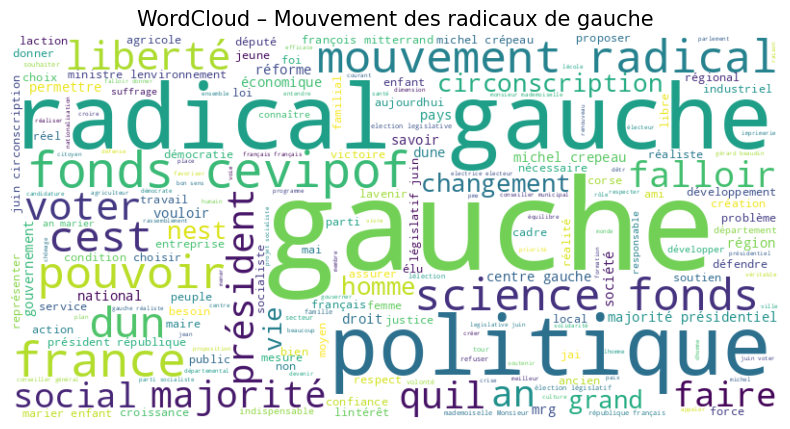

--- Génération du nuage pour la catégorie : Ligue communiste révolutionnaire ---


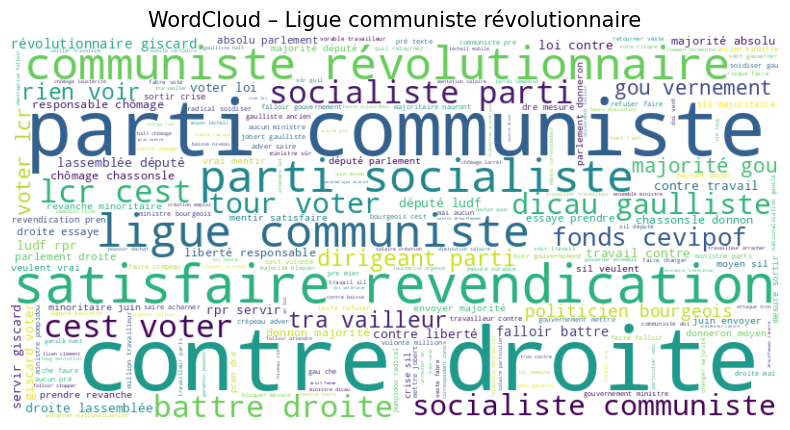

--- Génération du nuage pour la catégorie : Union pour la démocratie française;Rassemblement pour la République ---


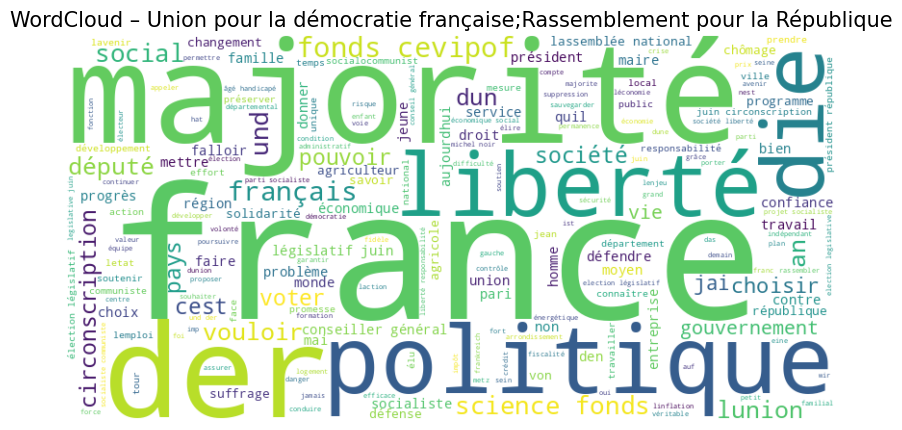

In [7]:
#1. Chargement des Stopwords (via spaCy pour éviter l'erreur de fichier)
nlp = spacy.load("fr_core_news_sm")
STOPWORDS = list(nlp.Defaults.stop_words)

# Facultatif : Ajouter des mots qui polluent souvent les nuages
STOPWORDS.extend(["candidat","suppléant"])

# 2. Boucle sur les catégories
for cat in df_final['titulaire-soutien'].unique():
    
    # Extraction et fusion du texte pour cette catégorie
    text_cat = " ".join(df_final[df_final['titulaire-soutien'] == cat]['clean_text'].astype(str))
    
    # On vérifie que le texte n'est pas vide avant de générer
    if text_cat.strip(): 
        print(f"--- Génération du nuage pour la catégorie : {cat} ---")
        
        # Création de l'objet WordCloud
        wc = WordCloud(
            stopwords=STOPWORDS, 
            width=800, 
            height=400, 
            background_color='white',
            colormap='viridis' # Optionnel : donne de jolies couleurs
        ).generate(text_cat)
        
        # Affichage avec Matplotlib
        plt.figure(figsize=(10, 5))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"WordCloud – {cat}", fontsize=15)
        plt.show()
    else:
        print(f"⚠️ Pas assez de données pour la catégorie : {cat}")

✅ Meilleurs paramètres trouvés : {'lr__C': 10.0, 'tfidf__max_features': 3000, 'tfidf__ngram_range': (1, 2)}

--- RAPPORT DE CLASSIFICATION (MODÈLE OPTIMISÉ) ---
                                                                     precision    recall  f1-score   support

                                                     Front national       1.00      1.00      1.00         9
                                   Ligue communiste révolutionnaire       1.00      1.00      1.00         6
                                                     Lutte ouvrière       1.00      1.00      1.00        32
                                   Mouvement des radicaux de gauche       1.00      1.00      1.00         9
                                          Parti communiste français       1.00      0.99      0.99        93
                                                   Parti socialiste       0.83      1.00      0.91        81
                                            Parti socialiste unifié       1

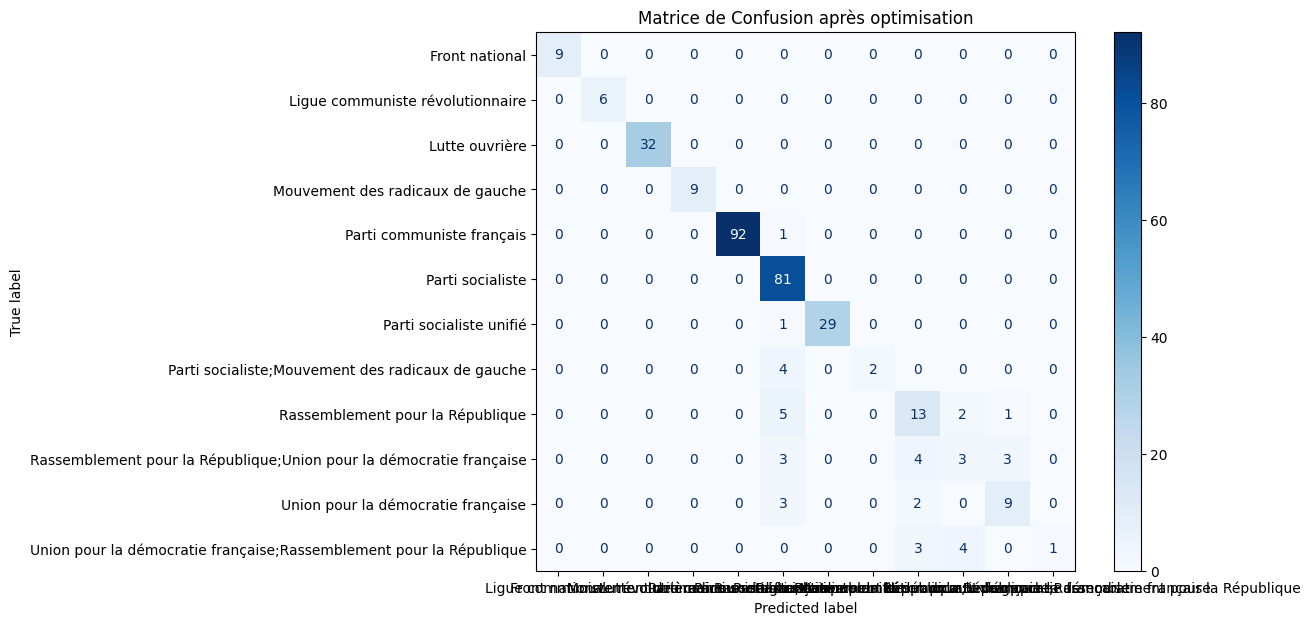

In [12]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. Préparation des données
X = df_final["clean_text"].astype(str)
y = df_final["titulaire-soutien"].astype(str)

# Split initial : on garde 20% pour le TEST FINAL
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# 2. Définition du Pipeline
pipe = Pipeline([
    ("tfidf", TfidfVectorizer()), 
    ("lr", LogisticRegression(max_iter=1000))
])

# 3. Grille de paramètres (Le "Dev Set" dynamique)
# On va tester différentes tailles de vocabulaire et forces de régularisation
param_grid = {
    'tfidf__max_features': [1000, 3000, 5000],
    'tfidf__ngram_range': [(1, 1), (1, 2)], # Mots seuls ou couples de mots
    'lr__C': [0.1, 1.0, 10.0]               # Force de la régression
}

# 4. Recherche des meilleurs paramètres (Cross-Validation à 5 plis)
# GridSearchCV divise le X_train en 5 : 4 pour l'entraînement, 1 pour le "Dev"
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)
grid.fit(X_train, y_train)

print(f"✅ Meilleurs paramètres trouvés : {grid.best_params_}")

# 5. Évaluation sur le Test Set (le vrai arbitre)
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

print("\n--- RAPPORT DE CLASSIFICATION (MODÈLE OPTIMISÉ) ---")
print(classification_report(y_test, y_pred))

# 6. Matrice de Confusion
fig, ax = plt.subplots(figsize=(10, 7))
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test, cmap='Blues', ax=ax)
plt.title("Matrice de Confusion après optimisation")
plt.show()

In [15]:
# 1. Suppression de la catégorie mixte PS;MRG
categories_a_supprimer = ['Parti socialiste;Mouvement des radicaux de gauche']
df_final = df_final[~df_final['titulaire-soutien'].isin(categories_a_supprimer)]

# 2. Regroupement RPR / UDF (comme vu précédemment)
mapping_droite = {
    'Rassemblement pour la République': 'Droite RPR-UDF',
    'Union pour la démocratie française': 'Droite RPR-UDF',
    'Rassemblement pour la République;Union pour la démocratie française': 'Droite RPR-UDF',
    'Union pour la démocratie française;Rassemblement pour la République': 'Droite RPR-UDF'
}
df_final['titulaire-soutien'] = df_final['titulaire-soutien'].replace(mapping_droite)

# Vérification : on regarde ce qu'il reste
print("Nouvelles catégories :", df_final['titulaire-soutien'].unique())
print("Nombre de lignes restantes :", len(df_final))

Nouvelles catégories : ['Parti socialiste unifié' 'Parti communiste français' 'Droite RPR-UDF'
 'Parti socialiste' 'Lutte ouvrière' 'Front national'
 'Mouvement des radicaux de gauche' 'Ligue communiste révolutionnaire']
Nombre de lignes restantes : 1577


✅ Meilleurs paramètres trouvés : {'lr__C': 10.0, 'tfidf__max_features': 1000, 'tfidf__ngram_range': (1, 2)}

--- RAPPORT DE CLASSIFICATION (MODÈLE OPTIMISÉ) ---
                                  precision    recall  f1-score   support

                  Droite RPR-UDF       0.93      0.98      0.96        56
                  Front national       1.00      1.00      1.00         9
Ligue communiste révolutionnaire       1.00      1.00      1.00         6
                  Lutte ouvrière       1.00      1.00      1.00        32
Mouvement des radicaux de gauche       1.00      0.78      0.88         9
       Parti communiste français       0.99      1.00      0.99        93
                Parti socialiste       0.96      0.96      0.96        81
         Parti socialiste unifié       1.00      0.93      0.97        30

                        accuracy                           0.97       316
                       macro avg       0.99      0.96      0.97       316
                    wei

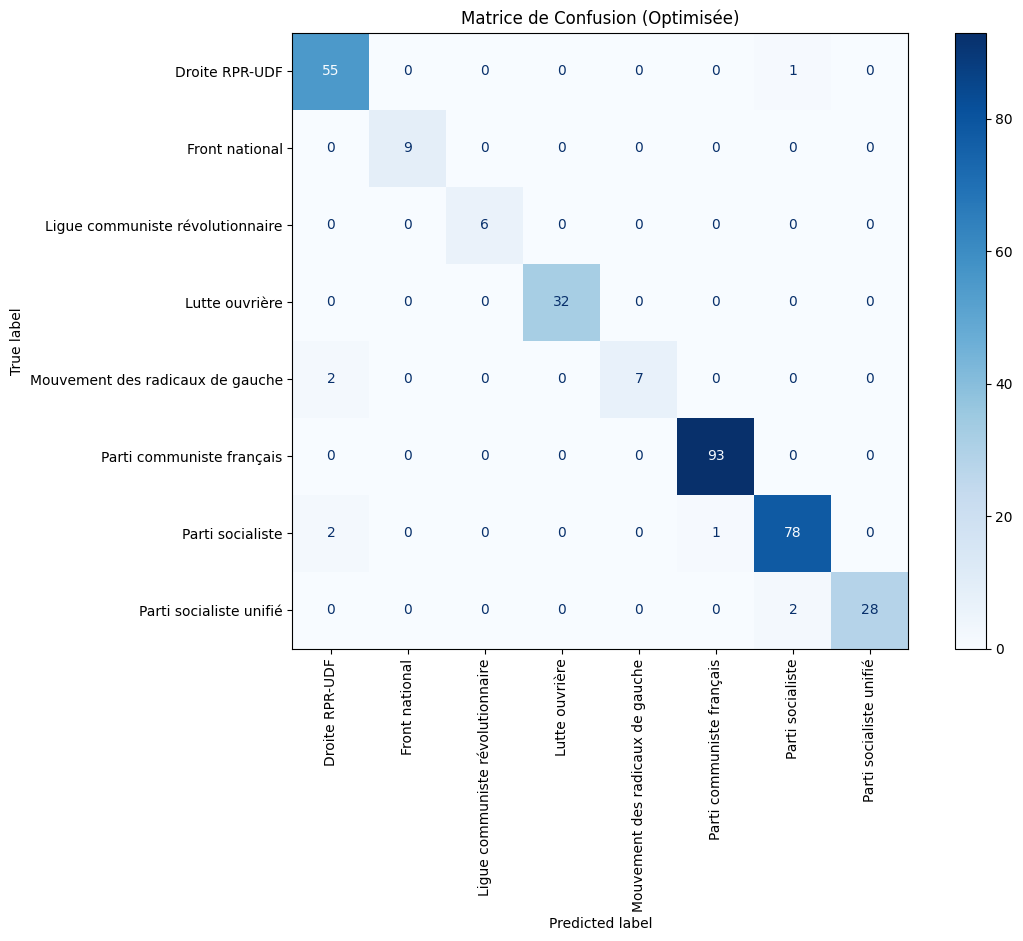

In [23]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. Préparation des données
X = df_final["clean_text"].astype(str)
y = df_final["titulaire-soutien"].astype(str)

# Split initial : on garde 20% pour le TEST FINAL
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# 2. Définition du Pipeline
pipe = Pipeline([
    ("tfidf", TfidfVectorizer()), 
    ("lr", LogisticRegression(max_iter=1000))
])

# 3. Grille de paramètres (Le "Dev Set" dynamique)
# On va tester différentes tailles de vocabulaire et forces de régularisation
param_grid = {
    'tfidf__max_features': [1000, 3000, 5000],
    'tfidf__ngram_range': [(1, 1), (1, 2)], # Mots seuls ou couples de mots
    'lr__C': [0.1, 1.0, 10.0]               # Force de la régression
}

# 4. Recherche des meilleurs paramètres (Cross-Validation à 5 plis)
# GridSearchCV divise le X_train en 5 : 4 pour l'entraînement, 1 pour le "Dev"
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)
grid.fit(X_train, y_train)

print(f"✅ Meilleurs paramètres trouvés : {grid.best_params_}")

# 5. Évaluation sur le Test Set (le vrai arbitre)
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

print("\n--- RAPPORT DE CLASSIFICATION (MODÈLE OPTIMISÉ) ---")
print(classification_report(y_test, y_pred))

# 6. Matrice de Confusion
fig, ax = plt.subplots(figsize=(12, 8)) # On agrandit la figure

disp = ConfusionMatrixDisplay.from_estimator(
    best_model, 
    X_test, 
    y_test, 
    xticks_rotation=90,  # <--- Rotation ici
    cmap='Blues', 
    ax=ax
)

plt.title("Matrice de Confusion (Optimisée)")
plt.show()

In [19]:
import numpy as np
import pandas as pd

# 1. On récupère le meilleur modèle et le vectoriseur depuis le pipeline
best_pipe = grid.best_estimator_
vectorizer = best_pipe.named_steps['tfidf']
classifier = best_pipe.named_steps['lr']

# 2. On récupère le vocabulaire (les mots)
feature_names = np.array(vectorizer.get_feature_names_out())

# 3. On boucle sur chaque catégorie pour voir ses coefficients
for i, class_name in enumerate(classifier.classes_):
    # Récupération des coefficients pour la classe i
    # (Note: en binaire, classifier.coef_ n'a qu'une ligne)
    if len(classifier.classes_) == 2:
        coefs = classifier.coef_[0] if i == 1 else -classifier.coef_[0]
    else:
        coefs = classifier.coef_[i]
    
    # On trie pour avoir les indices des 10 plus grands coefficients
    top_10_indices = np.argsort(coefs)[-10:]
    
    # On récupère les mots et leurs scores
    top_words = feature_names[top_10_indices]
    top_scores = coefs[top_10_indices]
    
    print(f"\n🚀 TOP 10 MOTS POUR : {class_name}")
    for word, score in zip(reversed(top_words), reversed(top_scores)):
        print(f"   {word:<15} : {score:.4f}")


🚀 TOP 10 MOTS POUR : Droite RPR-UDF
   union nouveau   : 3.5355
   union           : 3.2082
   société         : 3.0336
   lunion nouveau  : 2.9105
   lunion          : 2.7341
   nouveau majorité : 2.6779
   jacques         : 2.3191
   liberté         : 2.2746
   franc           : 2.0525
   progrès         : 1.8867

🚀 TOP 10 MOTS POUR : Front national
   patrie          : 4.0284
   front           : 3.9639
   rassemblement   : 2.2935
   national        : 2.1215
   liberté         : 1.4683
   pari            : 1.3094
   sortant         : 1.1449
   lenseignement   : 1.1232
   peine           : 1.0496
   public          : 1.0044

🚀 TOP 10 MOTS POUR : Ligue communiste révolutionnaire
   lcr             : 3.0013
   lunité          : 2.0078
   contre          : 1.5192
   droite          : 1.4200
   revendication   : 1.3758
   voie            : 1.3646
   contre droite   : 1.2550
   aucun           : 1.1739
   satisfaire      : 1.1456
   travailleur     : 1.0853

🚀 TOP 10 MOTS POUR : Lutte ou

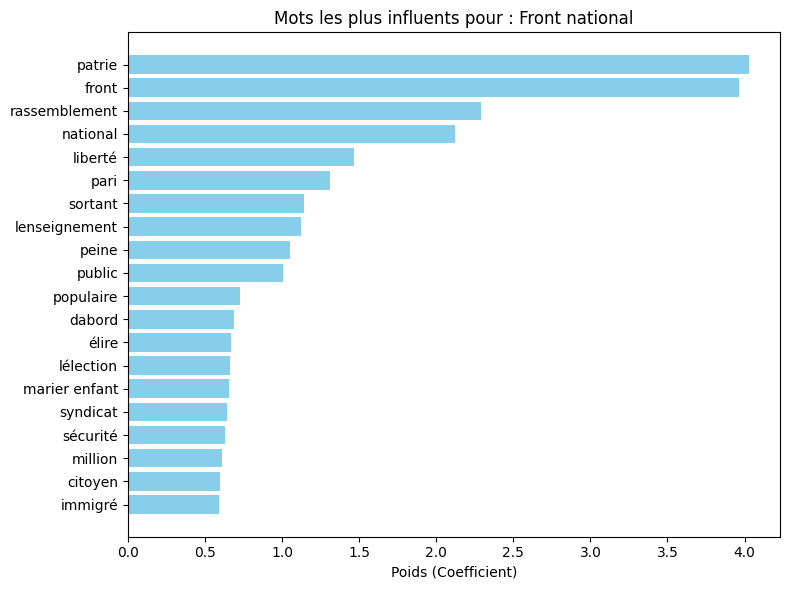

In [21]:
import matplotlib.pyplot as plt

def plot_top_coefficients(class_index):
    coefs = classifier.coef_[class_index]
    top_indices = np.argsort(coefs)[-20:]
    
    plt.figure(figsize=(8, 6))
    plt.barh(feature_names[top_indices], coefs[top_indices], color='skyblue')
    plt.title(f"Mots les plus influents pour : {classifier.classes_[class_index]}")
    plt.xlabel("Poids (Coefficient)")
    plt.tight_layout()
    plt.show()

# Exemple pour la première catégorie
plot_top_coefficients(1)

In [24]:
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Coefficients
coef = model.coef_[0]

# Odds ratios
odds_ratios = np.exp(coef)

# Mettre dans un DataFrame
feature_names = vectorizer.get_feature_names_out()

coef_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coef,
    "odds_ratio": odds_ratios
})

# Trier par importance
coef_df.sort_values("coefficient", ascending=False).head(10)


ValueError: could not convert string to float: 'election législatif juin circonscription seineetmarne chantal cauquil employer dassurance an candidat lutte ouvrier suppléant progrès esteban cheminot an travailleur travailleur cest nom lutte ouvrier formation présenter candidature darlette laguiller élection présidentiel solliciter suffrage élection présenter dun côté candidat rpr ludf séparément ensembl sigle lunion nouveau majorité lautre côté réclamer majorité présidentiel mitterrand falloir voter contre droite premier trop subir quart siècle majorité délecteur venir désavouer présidentielle nest évidemment ramener législative genslà ennemi salarié ouvrier employé représenter non intérêt petit paysan petit commerçant artisan cest côté quils chercher vote gouvernement quart paysannerie être chasser terre centaine millier jeune quitter campagne faute pouvoir vivre dizaine millier petit commerçant être pourchasser percepteur ruiner concurrence grand surface largent letat allaitau grand capital homme ami personnel dirigeant droite falloir voter gauche françois mitterrand présente homme gauche socialiste partisan changement faveur classe populaire beaucoup pensent permettre gouverner vraiment gauche vraiment changement falloir envoyer majorité gauche parlement bien sûr falloir espérer mitterrand tenir promesse quil fait domaine social quil augmenter smic créer emploi fonction public lessentiel mener politique bien prédécesseur appel darlette laguiller candidat mouvement lutte ouvrier élection présidentiel jai obtenir voix suf frage proportionnelle lutte ouvrier devoir électeur donner suffrage candidat député bien sûr loi électoral faire désavantager for mation voter lutte ouvrier cest vrai mentir voter député vraiment gauche décider cautionner davance faire mitterrand gouvernement tra vailleur euxmême approuve ront chambre faire faveur travailleur dénoncer conce sion tramerait contre laguiller science fonds cevipofdans passé participer gouvernement iv république defferre savary maurice faur sest montrer serviteur efficace intérêt bourgeoisie quelquesuns homme quil venir tirer néant loubli faire ministre important jobert ancien ministre pompidou delor ancien conseiller chabandelma homme droite peine déguiser gouvernement mettre place mitterrand montr bien quil réserve possibilité gouverner droite sil vouloir faire gauche fois élection passer fois consolidé gouvernement faire mitterrand ministre dire travailleur ouvrier petit paysan quil falloir raisonnable quil falloir modérer revendication aill mieux tard taxer petit commerçant sen prendre classe moyen prétendre cest nom travailleur quils quen réalité lont homme giscard chirac utiliser largent letat subventionner gros industrie biais budget force frappe larmée mitterrand annoncer quil toucher commande électronucléaire toucher falloir voter gauche cest sil falloir envoyer majorité gauche chambre seraitce ôter prétexte mitterrand réaliser travailleur attendre nimporte gauche falloir député homme femme peuple être capable critiquer gouvernement préparer mauvais coup contre nenvoyer chambre député socialiste cest donner chèque blanc mitterrand député propre parti pourraientil sopposer trop dépendant avenir carrière nest non compter député communiste fier aujourdhui faire partie majorité présidentiel mitterrand nont critique formuler contre querelle injure année précédent ligne parti communiste trop changeant trop marquer intérêt parti trop éloigner intérêt travailleur quon pouvoir fier député communiste cest lutte ouvrier présent candidat arlette laguiller candidat lutte ouvrier présidentielle montrer rester fidèle ellemême garder attitude face giscard face mitterrand côté vivre travail contre pouvoir haute finance grand capital continuer dénoncer dépense énorme letat faveur larmée faveur trust capitaliste femme dhomme manquer ici nécessaire être daccord idée être méfiant voir vis réserve septennat mitterrand ditesle voter candidature gauche nappartiens majorité présidentiel formation circonstance sengouffrer ambitieux carriériste voir travail majorité dentr méliser rester lun dentr ner ambition personnel carrière ménager fortune dépendre pouvoir place savoir changement fondamental société dépendre lutte travailleur composition parlement candidat lutte ouvrier élection arlette laguiller travailleuse travailleur rang sincérité francparler peuple mengage menvoyer lassemblée national soutenir laction gouvernement bon classe populaire mengage dénoncer néfaste juger digne représenter parlement fait député être non porteparole chambre député être ici combat lutte travailleur travailleur falloir voter gauche oui gauche voter travailleuse candidat dextrêmegauche voltair impression montreuil sciencer fonds cevipof'

Super, voici le code pour extraire les mots-clés discriminants (les plus importants) pour chaque catégorie.

Cette étape est le complément indispensable de votre nuage de mots : elle montre exactement quels leviers la Régression Logistique utilise pour prendre ses décisions. C'est l'argument ultime pour votre rendu !



. Comment l'utiliser dans votre rapport pour répondre au sujet :
Confusion des langages : Si vous remarquez que le mot "social" a un poids élevé à la fois pour le PS et le PCF, vous avez la preuve mathématique qu'ils "parlent la même langue".

Identification des Outliers : Un document qui utilise des mots "poids lourds" de la droite tout en étant étiqueté à gauche sera immédiatement repéré par le modèle comme un outlier ou une anomalie.

Validation par le sens : Si pour la catégorie INT (International), les mots avec les plus gros poids sont "étranger", "diplomatie" ou "frontière", vous prouvez que votre modèle a parfaitement "appris" le concept de la catégorie.